In [1]:
import os
import numpy as np
import pyfastx
import matplotlib.pyplot as plt
import pandas as pd

#https://biopython.org/docs/1.75/api/Bio.SeqIO.QualityIO.html
#http://biopython.org/DIST/docs/tutorial/Tutorial.html#sec79
# https://biopython.org/wiki/Split_large_file
# https://pypi.org/project/pyfastx/
# https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html


#examples:
# 69kB training_data/Sau/ugly/MS/180727-18-5425-18-01680_S8_L001_R1_001.fastq.gz
# 52MB training_data/Sau/ugly/MS/200204_20-00746_19-03927_S9_L000_R2_001.fastq.gz
# 250MB training_data/Sau/ugly/MS/200327_20-04029_20-00557_S26_L000_R2_001.fastq.gz
# 1.5GB training_data/Sau/ugly/MS/181002-18-6992-776-18_S2_L001_R2_001.fastq.gz

#### convert ascii quality with offset of 33 to phred score

In [2]:
def phred_score(quality):
    return ord(quality)-33

#### extract quality means and base contents per position

In [3]:
def extract_fastq_positions(path, max_len_estim=1000):
    phred_sum = max_len_estim*[0] # sum all qualities per position, initialize with enough space for max_len
    counts = max_len_estim*[0] # count occurences of each position
    base_content = {'G': max_len_estim*[0], #count occurences of each base per position
                    'C': max_len_estim*[0],
                    'A': max_len_estim*[0], 
                    'T': max_len_estim*[0],
                    'N': max_len_estim*[0]}
    # fill lists with values from fastq file
    for name, seq, qual in pyfastx.Fastq(path, build_index=False):
        for i in range(len(seq)):
            phred_sum[i] += phred_score(qual[i])
            counts[i] += 1
            base_content[seq[i]][i] += 1
    
    phred_sum = np.array(phred_sum)
    counts = np.array(counts)
    max_len = np.min(np.where(counts==0)) #find index of first 0 value as maximum length of sequences
    phred_sum = phred_sum[0:max_len]
    counts = counts[0:max_len]
    means = phred_sum/counts
    
    # convert the lists in base_content to np.arrays to perform calculations
    for key in base_content:
        base_content[key] = np.array(base_content[key])
    max_len = np.min(np.where(base_content['G']==0)) #find index of first 0 value as maximum length of sequences
    for key in base_content:
        base_content[key] = base_content[key][0:max_len] #remove unused positions
    #sum all occurences to calculate percentages
    sums = (base_content['G'] + base_content['C'] + base_content['T'] +
            base_content['A'] + base_content['N'])
    ncontent_total = base_content['N'].sum()/sums.sum()
    for key in base_content:
        base_content[key] = base_content[key]/sums
    
    return means, base_content, ncontent_total

#### import fastq files from directories and extract positional data

In [4]:
#from datetime import datetime #remove

def import_reads(rootdir):
    filenames = []
    all_phred_means = []
    all_base_content = []
    all_n_content = []
    for root, dirs, files in os.walk(rootdir):
        for name in files:
            filepath = root + os.sep + name
            if filepath.endswith(".fastq.gz"):
                phred_means, base_content, n_content = extract_fastq_positions(filepath)
                all_phred_means.append(phred_means)
                all_base_content.append(base_content)
                all_n_content.append(n_content)
                filenames.append(name.replace(".fastq.gz", ""))
                #print("finished " + filepath + " " + str(datetime.now(tz=None)))
    
    fastq_positions = pd.DataFrame(all_base_content, columns=['G', 'C', 'A', 'T', 'N'])
    fastq_positions['filename']= filenames
    fastq_positions['phred_means'] = all_phred_means
    fastq_positions['n_content'] = all_n_content
    
    return fastq_positions

In [5]:
# runtime ~4hrs for 184 files
position_data = import_reads('training_data')

0 finished training_data/Sau/ugly/MS/200327_20-04028_20-00328_S25_L000_R1_001.fastq.gz 2022-03-18 17:56:34.735101
1 finished training_data/Sau/ugly/MS/200709_20-07968_20-00891_S21_L000_R1_001.fastq.gz 2022-03-18 17:57:03.841202
2 finished training_data/Sau/ugly/MS/181002-18-6992-776-18_S2_L001_R2_001.fastq.gz 2022-03-18 18:05:30.328279
3 finished training_data/Sau/ugly/MS/200327_20-04029_20-00557_S26_L000_R1_001.fastq.gz 2022-03-18 18:07:11.067387
4 finished training_data/Sau/ugly/MS/200204_20-00744_19-03870_S7_L000_R2_001.fastq.gz 2022-03-18 18:07:47.029821
5 finished training_data/Sau/ugly/MS/200709_20-07969_20-00894_S22_L000_R1_001.fastq.gz 2022-03-18 18:08:15.246733
6 finished training_data/Sau/ugly/MS/200204_20-00746_19-03927_S9_L000_R2_001.fastq.gz 2022-03-18 18:08:31.547322
7 finished training_data/Sau/ugly/MS/200204_20-00744_19-03870_S7_L000_R1_001.fastq.gz 2022-03-18 18:09:07.842854
8 finished training_data/Sau/ugly/MS/200709_20-07969_20-00894_S22_L000_R2_001.fastq.gz 2022-03-

72 finished training_data/Sau/good/HS/191113_19-10416_19-02942_S175_L000_R1_001.fastq.gz 2022-03-18 20:03:57.755252
73 finished training_data/Sau/good/HS/191113_19-10417_19-02943-1_S176_L000_R2_001.fastq.gz 2022-03-18 20:05:25.676859
74 finished training_data/Sau/good/HS/191113_19-10419_19-02944-1_S178_L000_R1_001.fastq.gz 2022-03-18 20:06:30.697855
75 finished training_data/Sau/good/HS/191113_19-10422_19-02946_S181_L000_R1_001.fastq.gz 2022-03-18 20:07:34.560688
76 finished training_data/Sau/good/HS/191113_19-10422_19-02946_S181_L000_R2_001.fastq.gz 2022-03-18 20:08:38.787032
77 finished training_data/Sau/good/HS/191113_19-10417_19-02943-1_S176_L000_R1_001.fastq.gz 2022-03-18 20:10:06.720761
78 finished training_data/Ecoli/ugly/MS/190917-19-08343-NRZ-52602_S15_L001_R1_001.fastq.gz 2022-03-18 20:10:06.792300
79 finished training_data/Ecoli/ugly/MS/190917-19-08343-NRZ-52602_S15_L001_R2_001.fastq.gz 2022-03-18 20:10:06.863227
80 finished training_data/Ecoli/ugly/MS/190917-19-08319-NRZ-51

143 finished training_data/Efcm/good/MS/190318-19-01844-UW19607_S6_L001_R1_001.fastq.gz 2022-03-18 21:08:26.291369
144 finished training_data/Efcm/good/MS/190315-19-01867-UW19729_S2_L001_R2_001.fastq.gz 2022-03-18 21:09:17.809503
145 finished training_data/Efcm/good/MS/190318-19-01846-UW19617_S8_L001_R2_001.fastq.gz 2022-03-18 21:10:03.536090
146 finished training_data/Efcm/good/NX/200117_20-00173_UW20644_S52_L000_R1_001.fastq.gz 2022-03-18 21:12:05.278187
147 finished training_data/Efcm/good/NX/200117_20-00170_UW20641_S49_L000_R1_001.fastq.gz 2022-03-18 21:13:48.440135
148 finished training_data/Efcm/good/NX/200117_20-00169_UW20640_S48_L000_R1_001.fastq.gz 2022-03-18 21:14:44.279198
149 finished training_data/Efcm/good/NX/200211_20-00763_20495_S43_L000_R1_001.fastq.gz 2022-03-18 21:16:41.103695
150 finished training_data/Efcm/good/NX/200211_20-00762_20488_S42_L000_R1_001.fastq.gz 2022-03-18 21:18:25.579169
151 finished training_data/Efcm/good/NX/200117_20-00172_UW20643_S51_L000_R1_001

#### export dataset

In [6]:
position_data.to_json('exported_datasets/from_fastq_raw.json')

#### Stuff for feature engineering, can be deleted after implemented in the other notebooks

In [50]:
def plot_acgt(index):
    plt.plot(bases[index]['G'])
    plt.plot(bases[index]['C'])
    plt.plot(bases[index]['T'])
    plt.plot(bases[index]['A'])

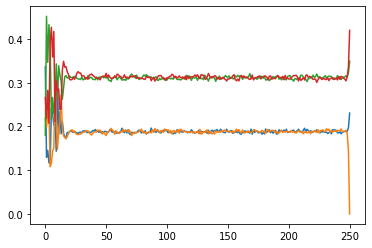

In [51]:
plot_acgt(183)

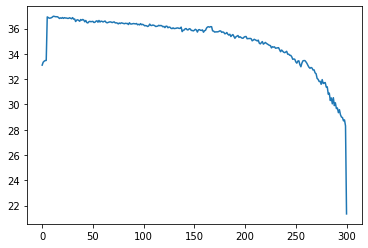

In [105]:
plt.plot(fastq_raw['phred_means'][88])

G content differences

In [342]:
g = np.ediff1d(fastq_raw['G'][1])
c = np.ediff1d(fastq_raw['C'][1])
t = np.ediff1d(fastq_raw['T'][1]) 
a = np.ediff1d(fastq_raw['A'][1])

In [343]:
g = np.absolute(g)
c = np.absolute(c)
t = np.absolute(t)
a = np.absolute(a)

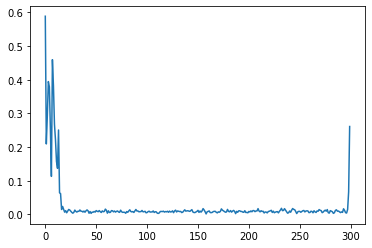

In [344]:
sums = g+c+t+a
plt.plot(sums)

In [345]:
g.std() + c.std() + t.std() + a.std()

0.08163089142334412

In [339]:
g.std() + c.std() + t.std() + a.std()

0.08492146656329563

In [346]:
sums.std()

0.06774930621425881

In [347]:
sums.mean()

0.023441879782546395

In [358]:
fastq_raw['n_count'][6].sum()

38231

Exploring Feature Engineering

20.49924379251646 2.677058836051526 0 1


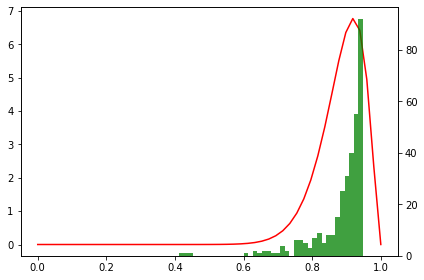

In [260]:
from scipy.stats import beta

quality_means = quality_mean/40

a, b, loc, scale  = beta.fit(quality_means, floc=0, fscale=1)#/38, floc=0, fscale=1)
print(a, b, loc, scale)
x = np.linspace(0, 1, 50)

pdf = beta.pdf(x, a, b, loc, scale)

fig, ax1 = plt.subplots()
ax1.plot(x, pdf, "r-")#, x, y2, "r--", x, y3, "g--")
ax2 = ax1.twinx()
ax2.hist(quality_means, alpha=0.75, color='green', bins=40)
fig.tight_layout()
plt.show()

3.571349205422848 1.1457908124416498 0 1


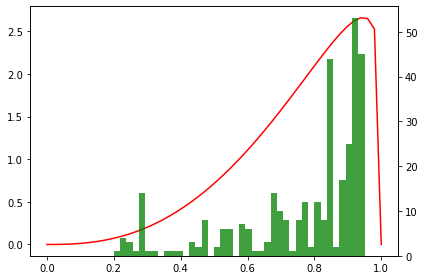

In [259]:
from scipy.stats import beta

quality_means = quality_10_percentile/40

a, b, loc, scale  = beta.fit(quality_means, floc=0, fscale=1)#/38, floc=0, fscale=1)
print(a, b, loc, scale)
x = np.linspace(0, 1, 50)

pdf = beta.pdf(x, a, b, loc, scale)

fig, ax1 = plt.subplots()
ax1.plot(x, pdf, "r-")#, x, y2, "r--", x, y3, "g--")
ax2 = ax1.twinx()
ax2.hist(quality_means, alpha=0.75, color='green', bins=40)
fig.tight_layout()
plt.show()